In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [3]:
train = False

In [4]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [5]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [6]:
epoch = 250

In [7]:
root = 'src/data/black_box_controller/explo'

In [8]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03482499,  0.06227159], dtype=float32), array([ 0.06171047, -0.00950113], dtype=float32), array([0.00205768, 0.00243432], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


-0.0003069480895944841


<IPython.core.display.Javascript object>


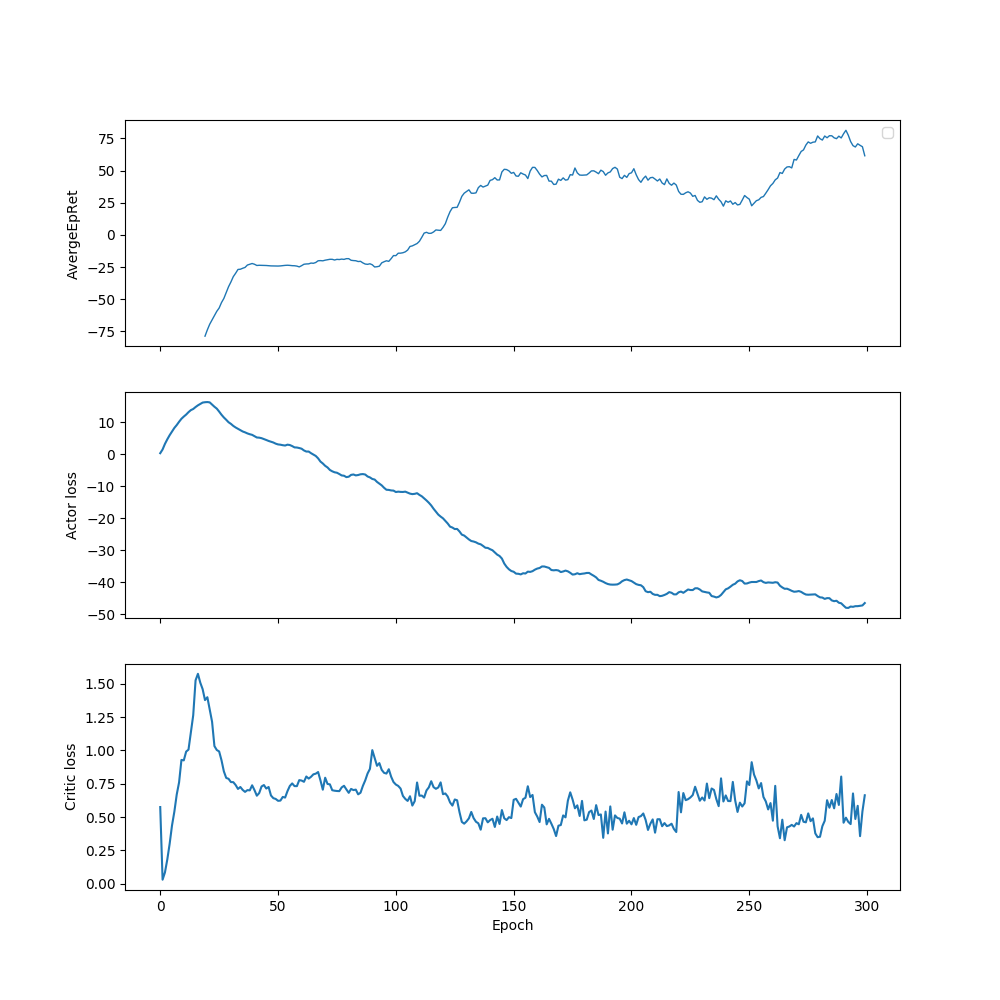

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


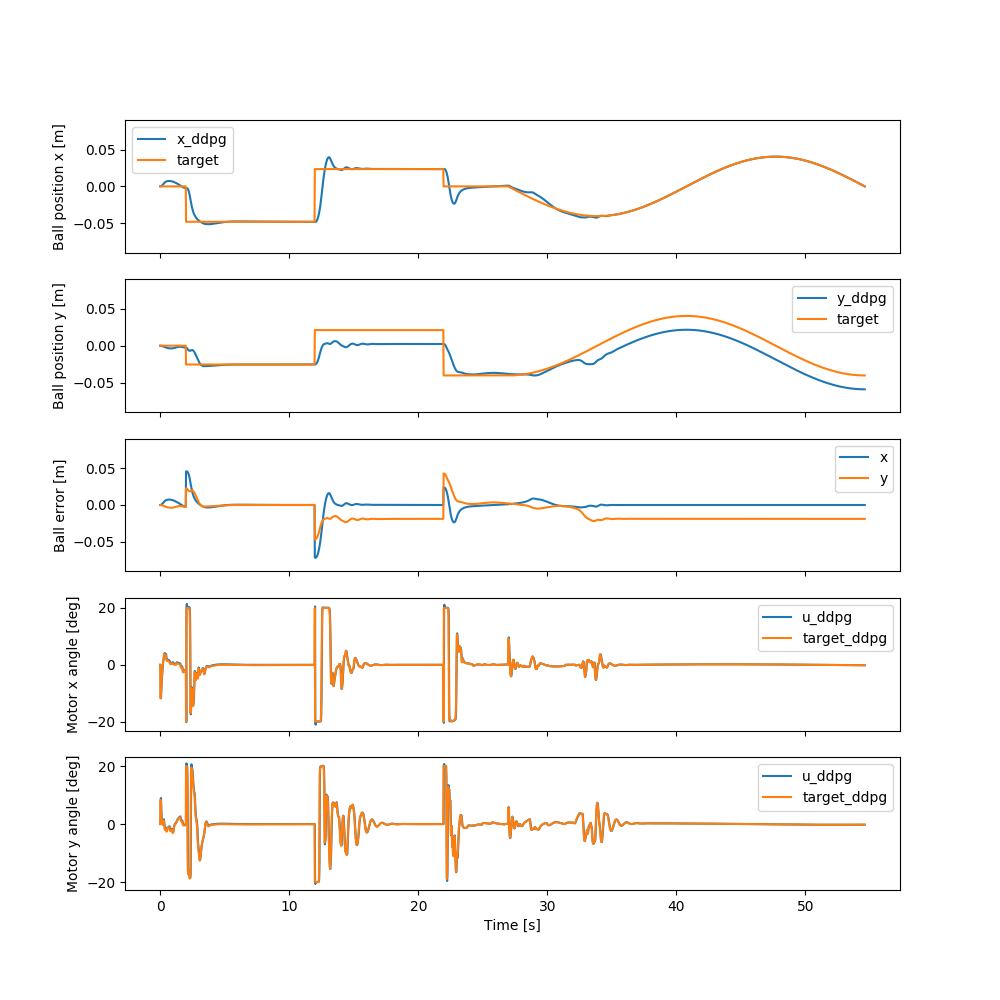

In [9]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [38]:
w = trained_ac.pi.state_dict()

saved_weights = {}
for key, value in w.items():
    saved_weights[key] = value.detach().numpy().tolist()
    
with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
    json.dump(saved_weights, json_file, indent=1)

In [10]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0099457 ,  0.05217337], dtype=float32), array([-0.04320891,  0.05049558], dtype=float32), array([ 0.0017452 , -0.00078499], dtype=float32))
-0.00016916548421626006


<IPython.core.display.Javascript object>


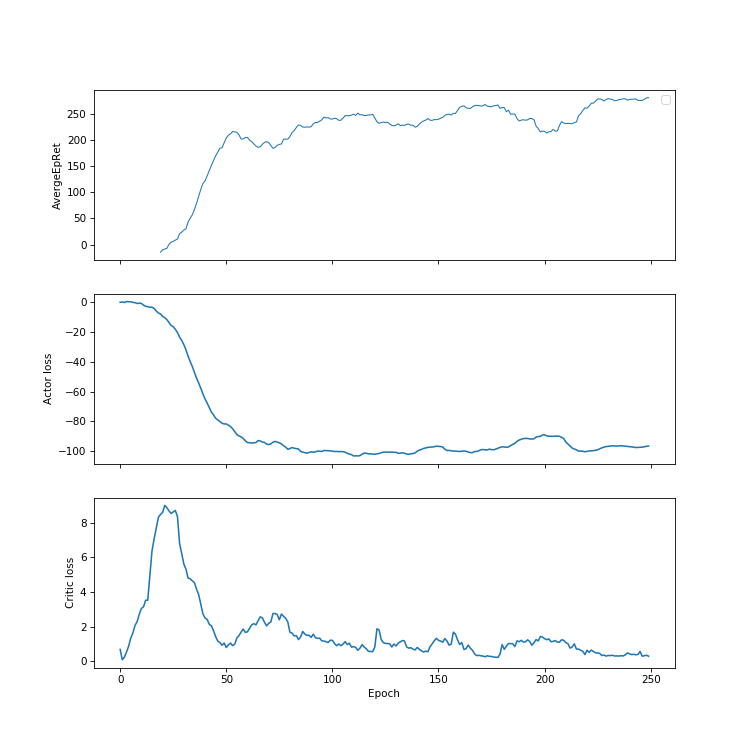

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


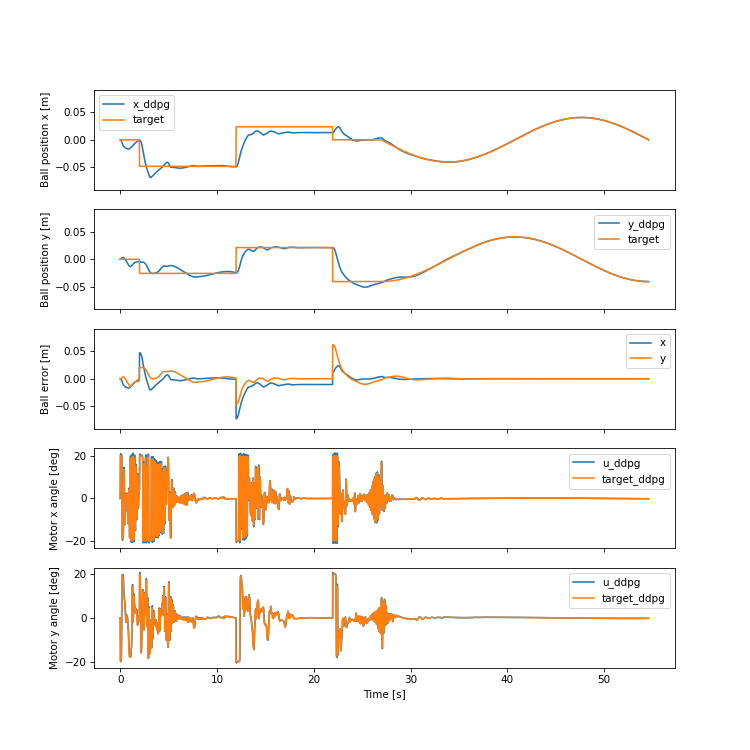

In [11]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [17]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.3_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05644637, -0.005075  ], dtype=float32), array([ 0.04134709, -0.01939608], dtype=float32), array([-0.00107524, -0.00107887], dtype=float32))
-19810.662762983746


<IPython.core.display.Javascript object>


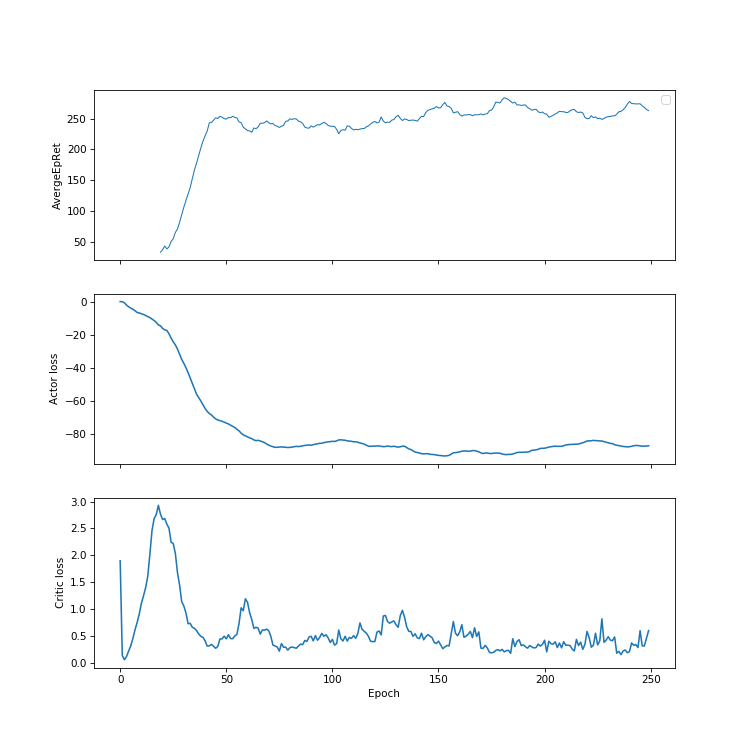

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


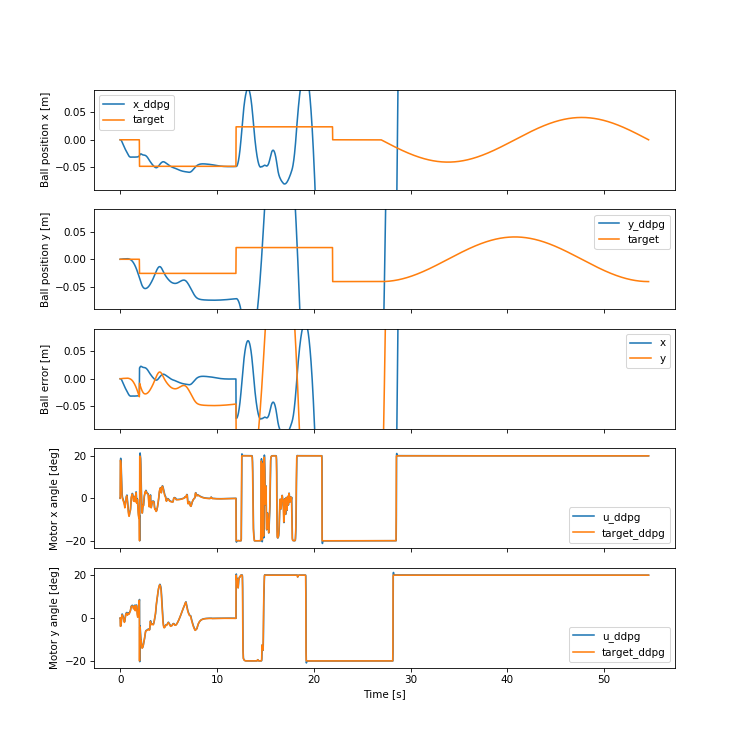

In [18]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [19]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04660679, -0.03331466], dtype=float32), array([-0.02298297,  0.01141447], dtype=float32), array([5.9764145e-05, 7.8699674e-04], dtype=float32))
-0.0014316889869751001


<IPython.core.display.Javascript object>


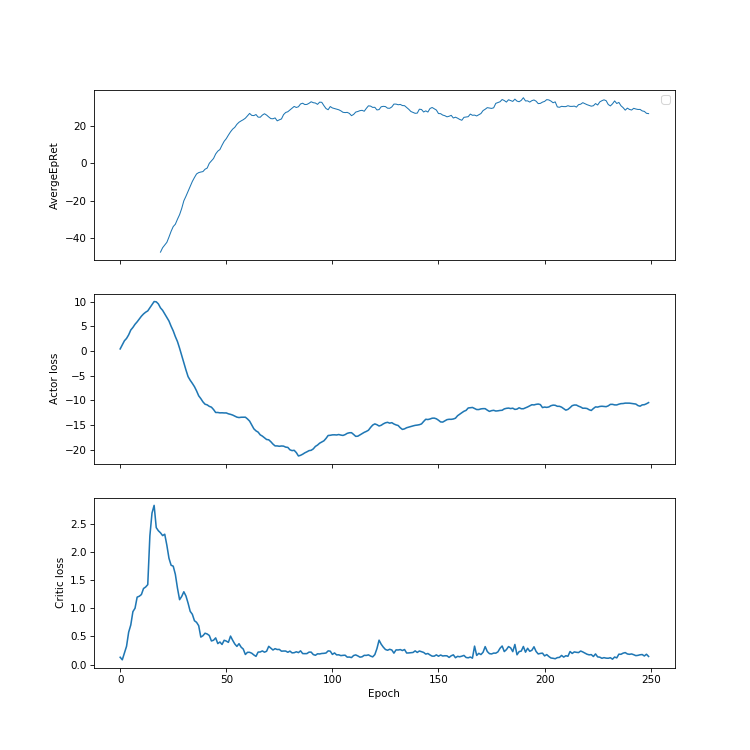

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


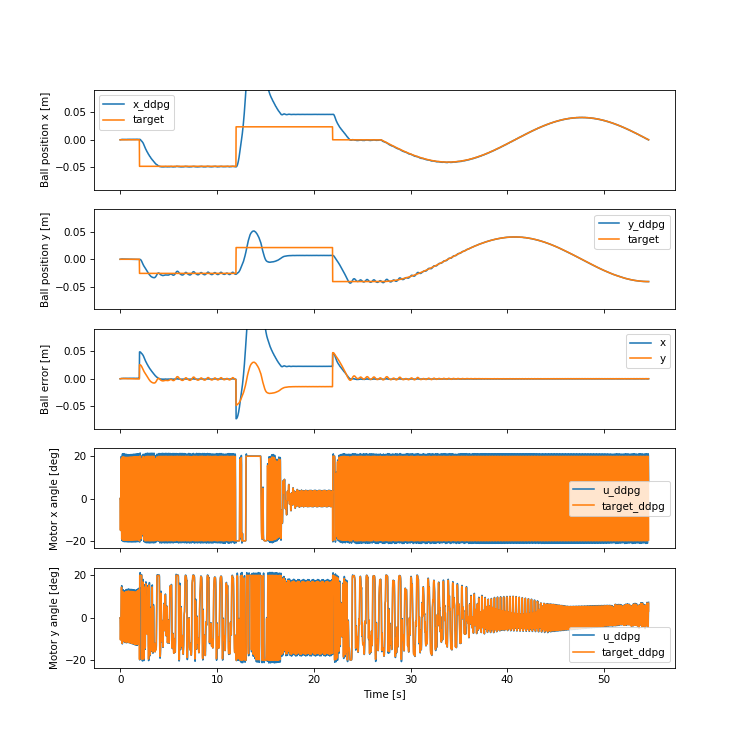

In [20]:
if False:#train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 15000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [21]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='le0.3_[100]_signmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.06266387, -0.05674656], dtype=float32), array([-0.06182993, -0.02003893], dtype=float32), array([-0.00164198, -0.00142502], dtype=float32))
-4.007780417553988


<IPython.core.display.Javascript object>


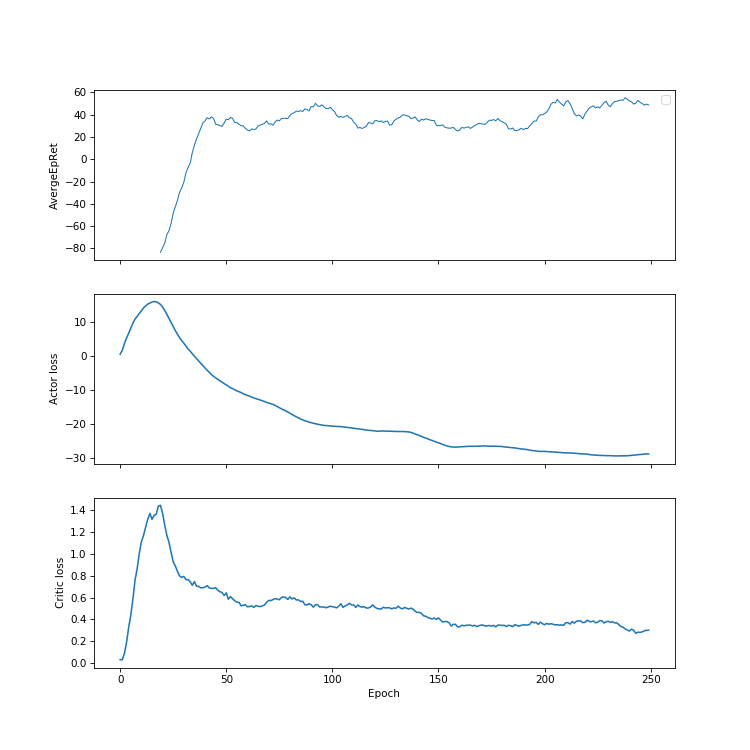

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


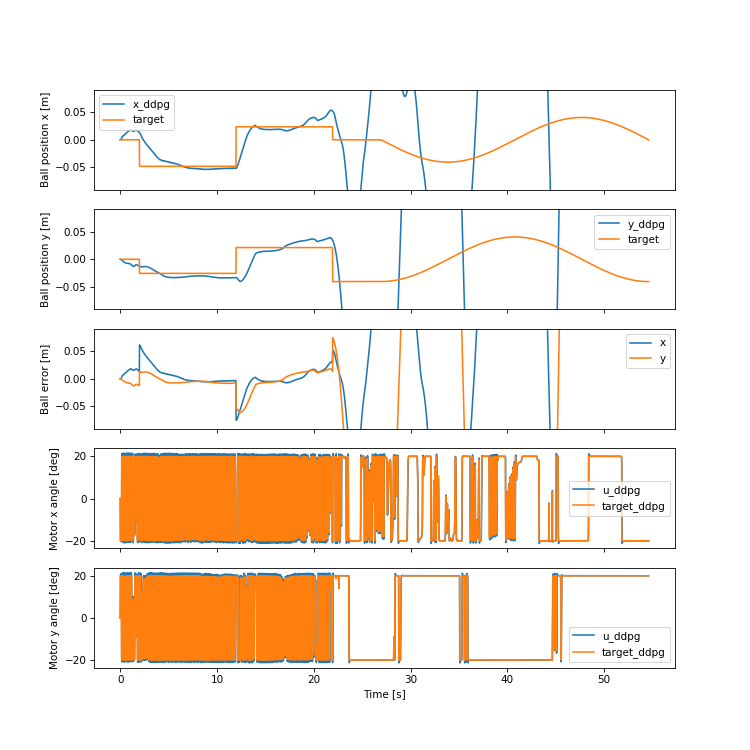

In [22]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 150000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [23]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pe1_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03836992, -0.04698997], dtype=float32), array([0.06407987, 0.06660823], dtype=float32), array([ 0.00185433, -0.00140542], dtype=float32))
-0.0008167436327208523


<IPython.core.display.Javascript object>


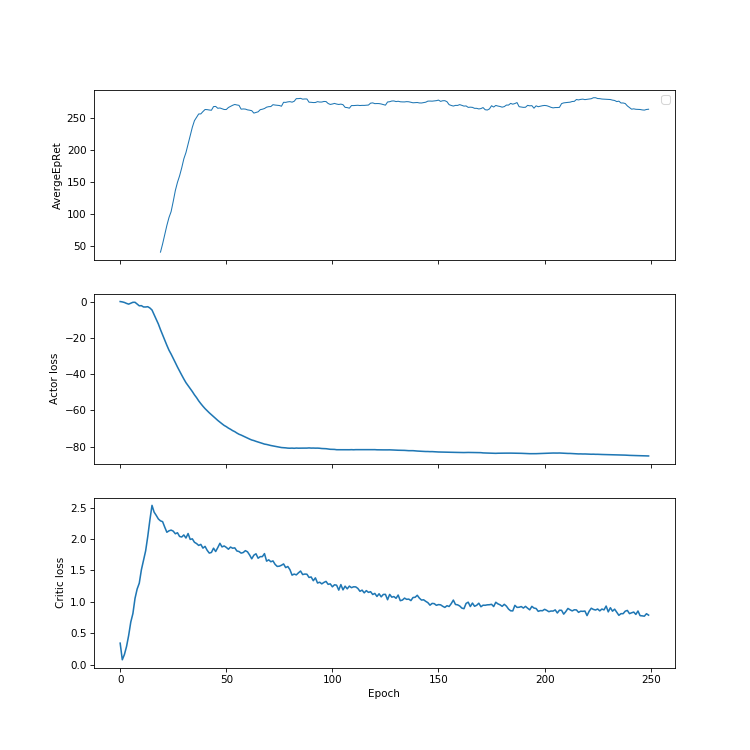

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


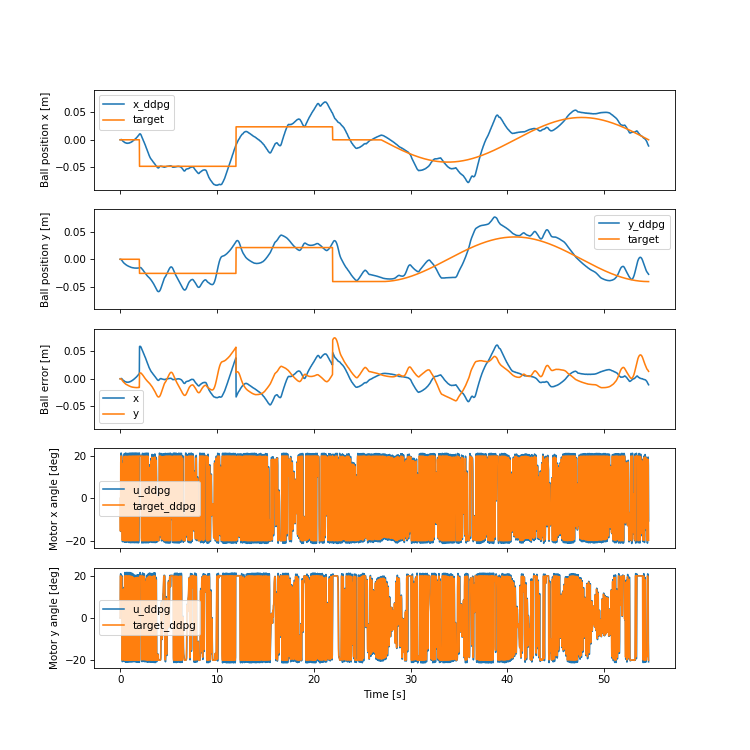

In [24]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [27]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Sigmoid
name='pep0.3_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03339386, 0.02813942], dtype=float32), array([ 0.04612328, -0.02941524], dtype=float32), array([-0.00057288, -0.00298265], dtype=float32))
-0.0007985239095186683


<IPython.core.display.Javascript object>


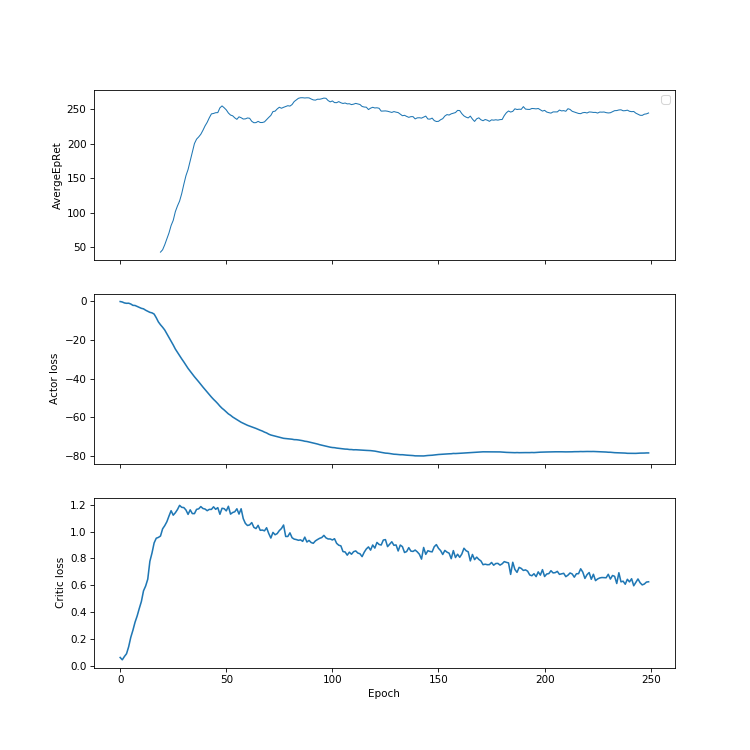

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


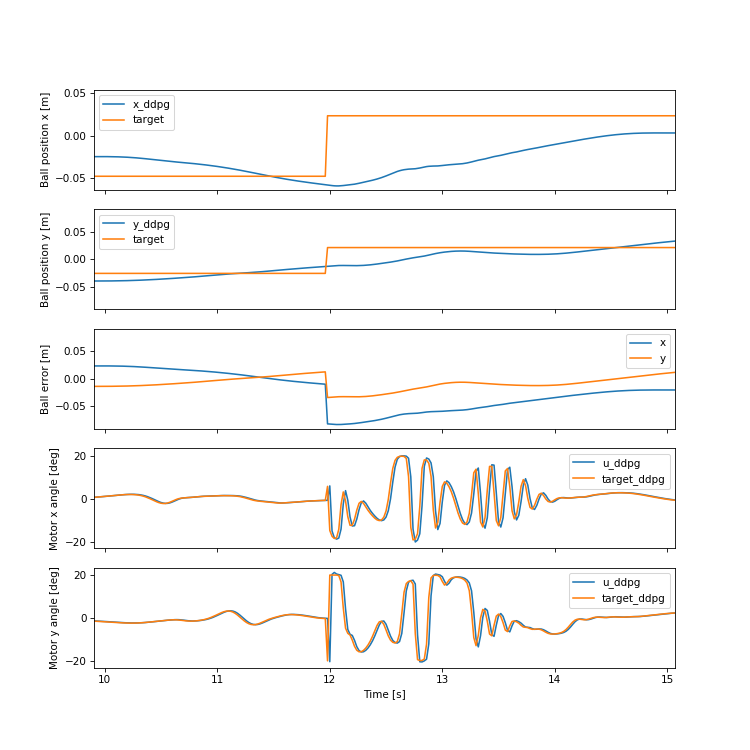

In [28]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [29]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100]_sigmoid_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05288829,  0.04258159], dtype=float32), array([-0.0261216 ,  0.03821442], dtype=float32), array([ 0.00139652, -0.00230901], dtype=float32))
-0.0001462247214260638


<IPython.core.display.Javascript object>


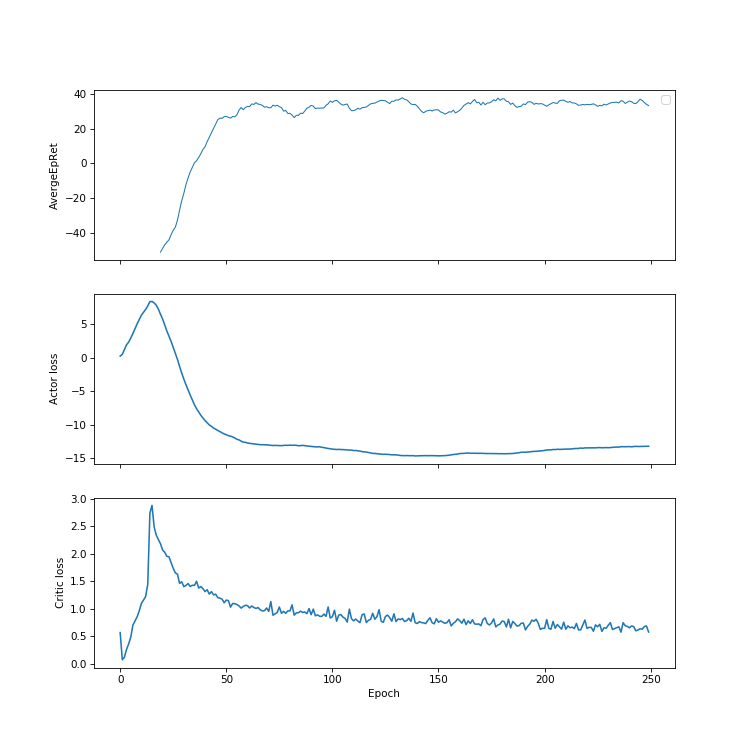

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


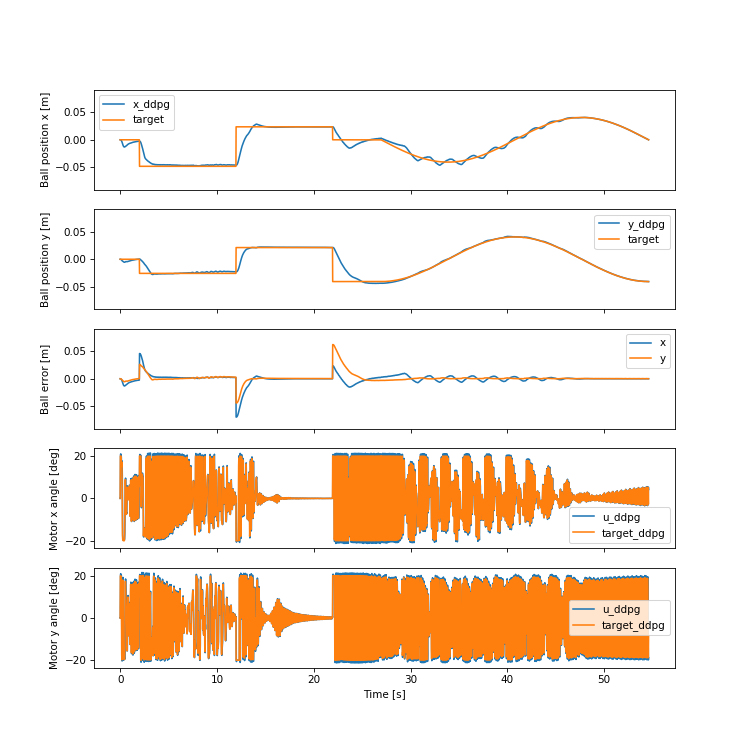

In [30]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [31]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='le0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.04970802, -0.06741697], dtype=float32), array([-0.06312466,  0.00382418], dtype=float32), array([ 0.00210007, -0.00293426], dtype=float32))
-0.0001550869582021654


<IPython.core.display.Javascript object>


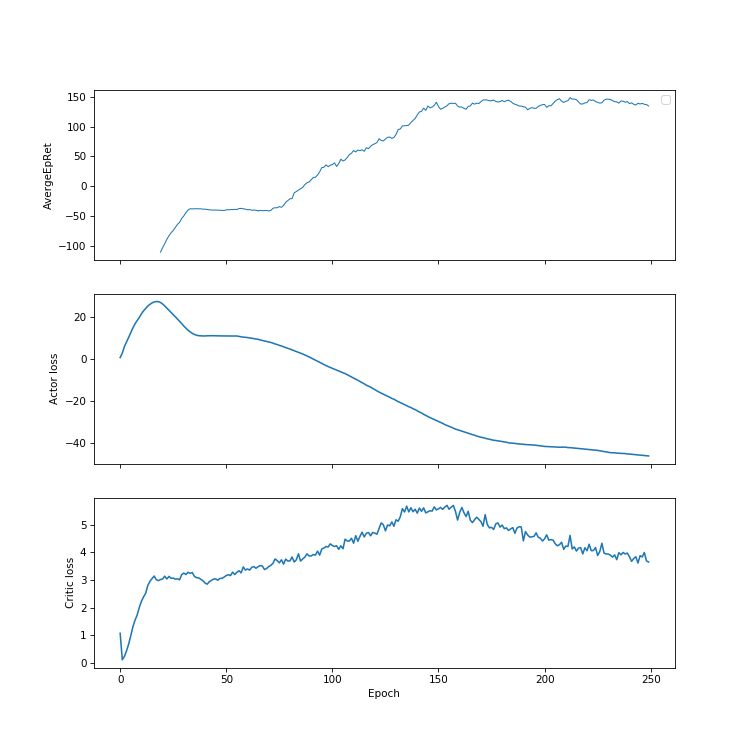

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


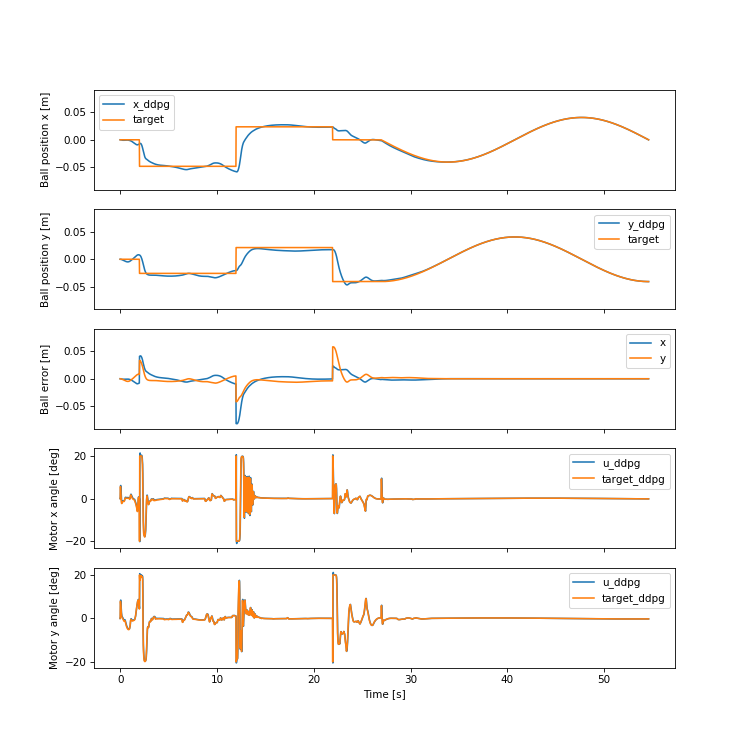

In [32]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [33]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1.4
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pe1.4_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03029759, 0.0678623 ], dtype=float32), array([ 0.01162623, -0.01233075], dtype=float32), array([0.00175703, 0.00206184], dtype=float32))
-0.0002303432219834078


<IPython.core.display.Javascript object>


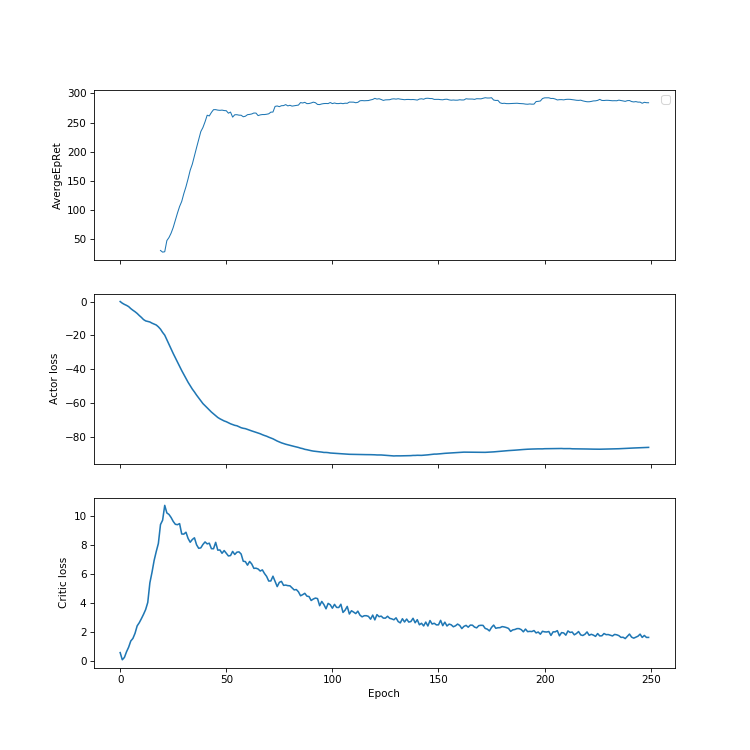

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


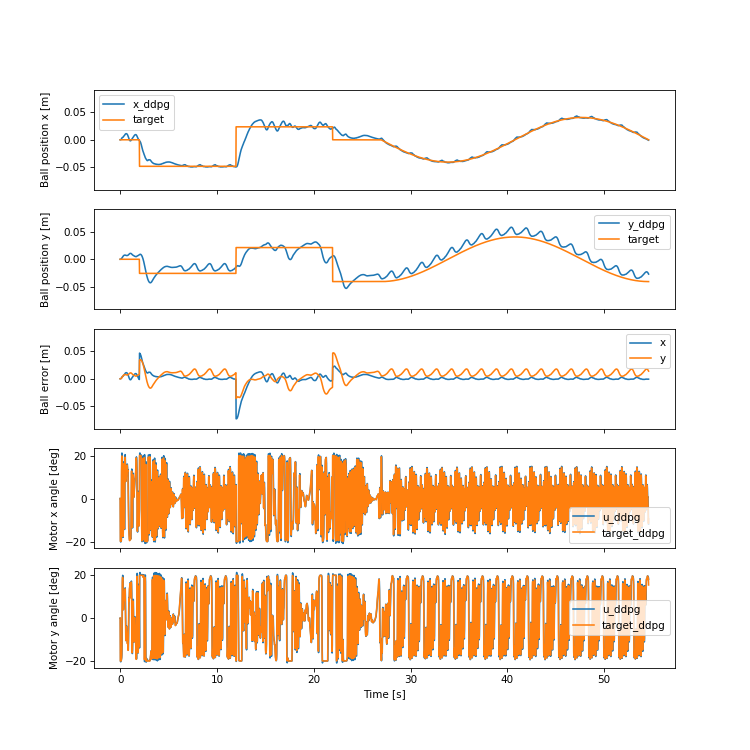

In [34]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [35]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.6
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.6_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.02608139, 0.02913044], dtype=float32), array([-0.02140657, -0.01024608], dtype=float32), array([ 0.00152079, -0.00230856], dtype=float32))
-0.0030130292850828098


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


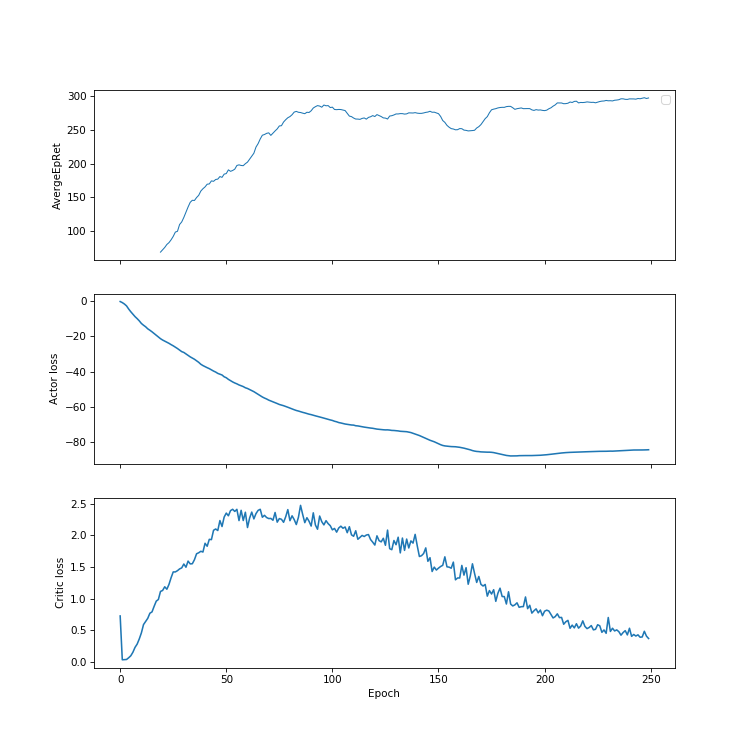

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


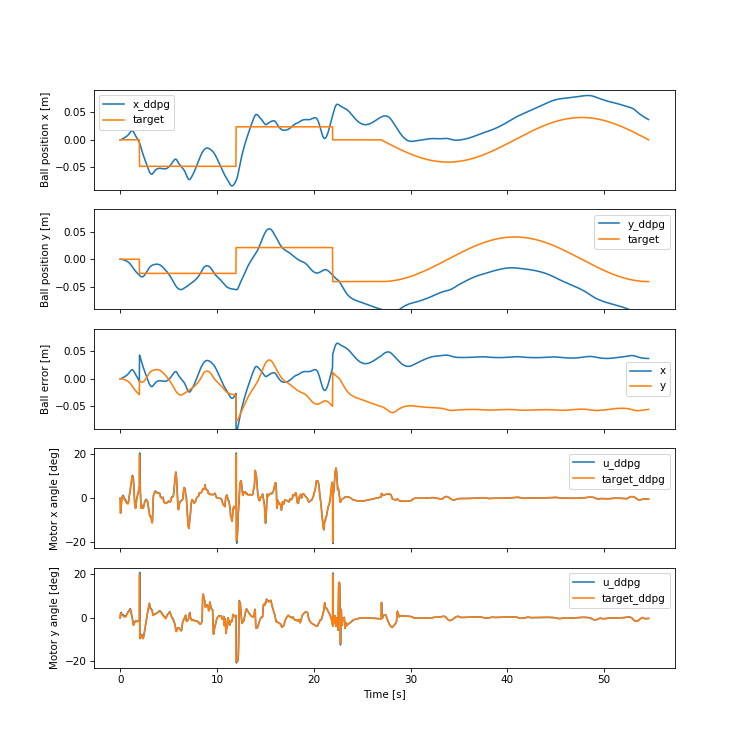

In [36]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [37]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 5
hidden_size = [100]
gamma = 0.99
act = torch.nn.ReLU
name='de5_[100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.00261849, -0.01049886], dtype=float32), array([0.0646392 , 0.00397519], dtype=float32), array([0.00091289, 0.00253224], dtype=float32))
-0.0013157208634683585


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


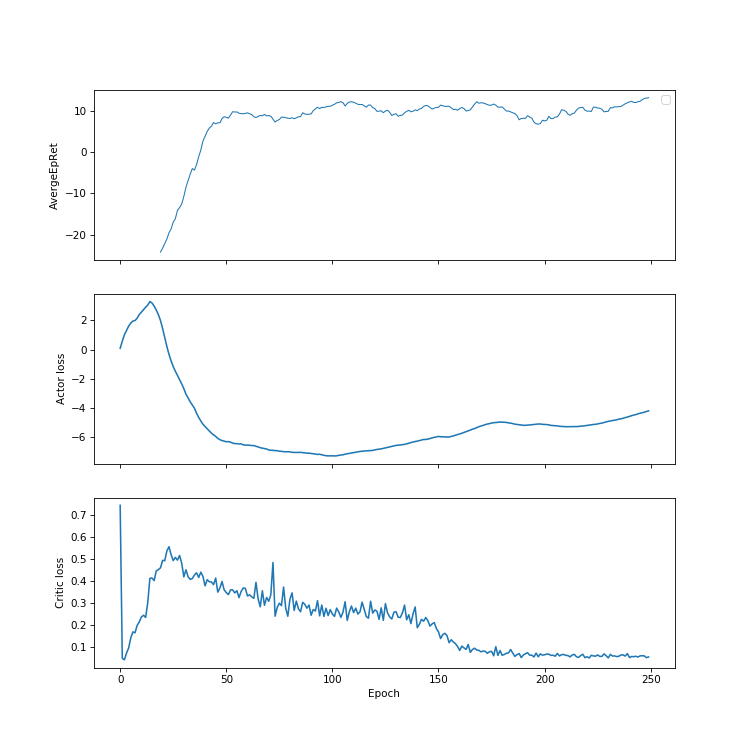

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


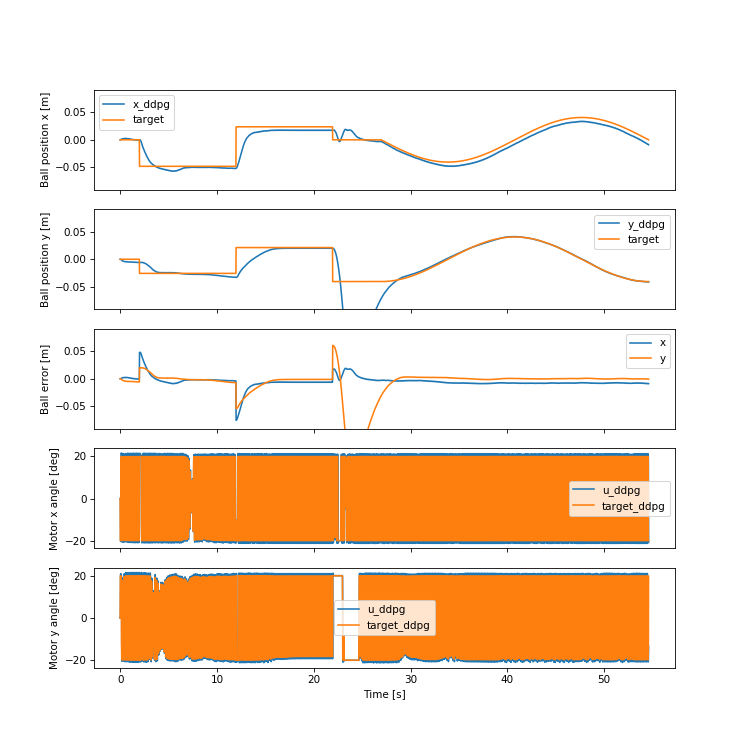

In [38]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [39]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='le0.3_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([ 0.01668307, -0.01062645], dtype=float32), array([ 0.01862344, -0.00481967], dtype=float32), array([0.00269088, 0.00071004], dtype=float32))
-0.0003999051444368726


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


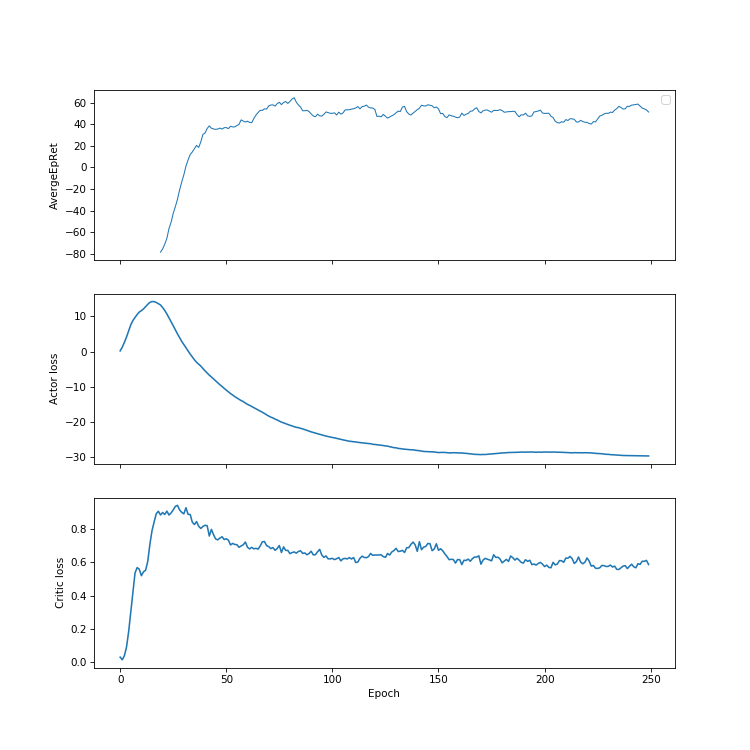

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


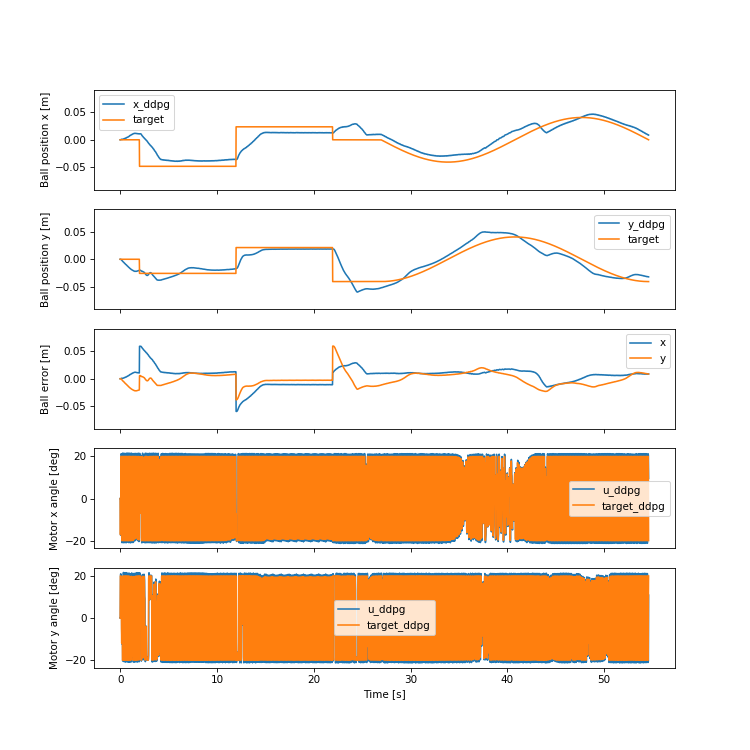

In [40]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [41]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='pe1_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03066687, -0.00518347], dtype=float32), array([-0.03980817, -0.0704216 ], dtype=float32), array([-0.00033774,  0.00261446], dtype=float32))
-0.0009873619166901112


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


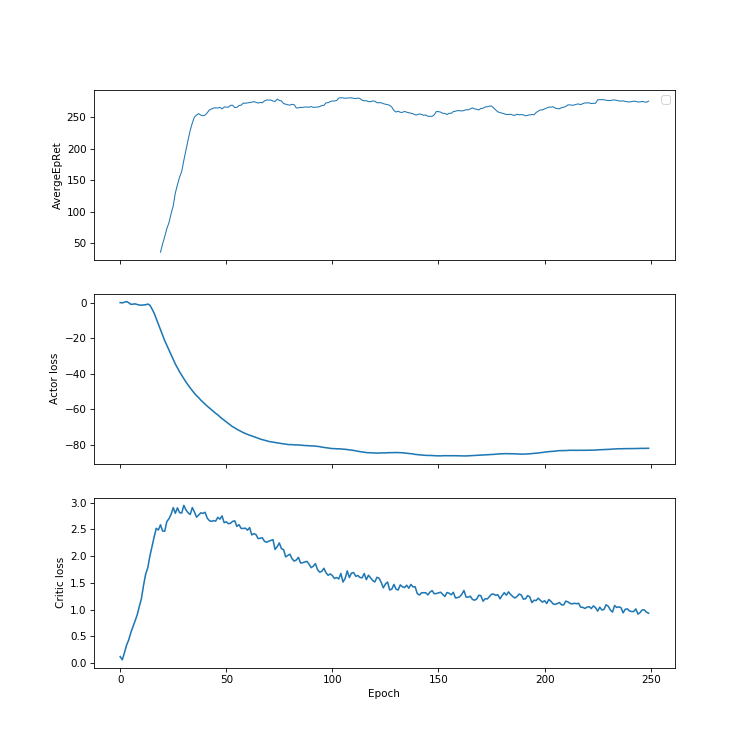

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


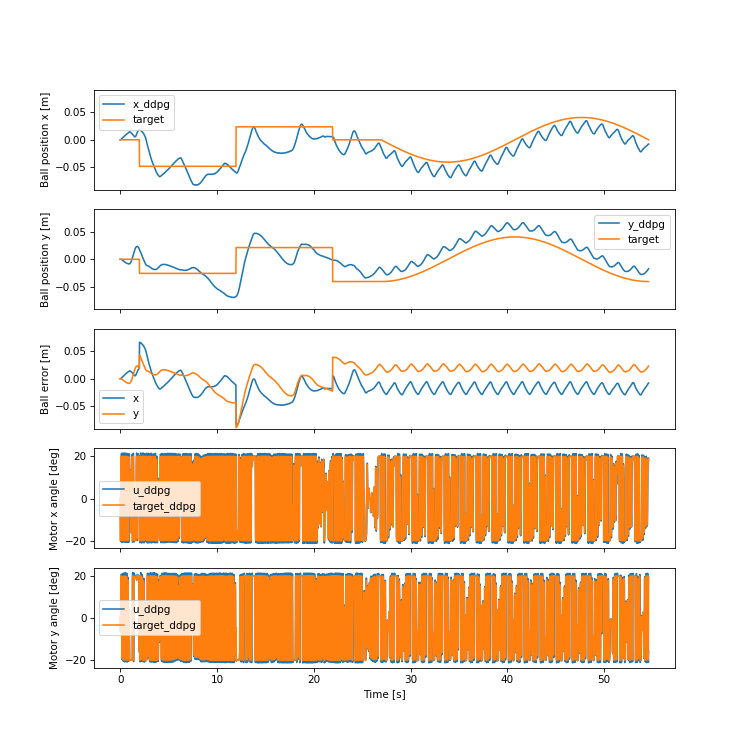

In [42]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [43]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='pep0.3_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.06306259, -0.05584435], dtype=float32), array([-0.04929224, -0.03899844], dtype=float32), array([0.00261852, 0.0003136 ], dtype=float32))
-0.0037221907826917957


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


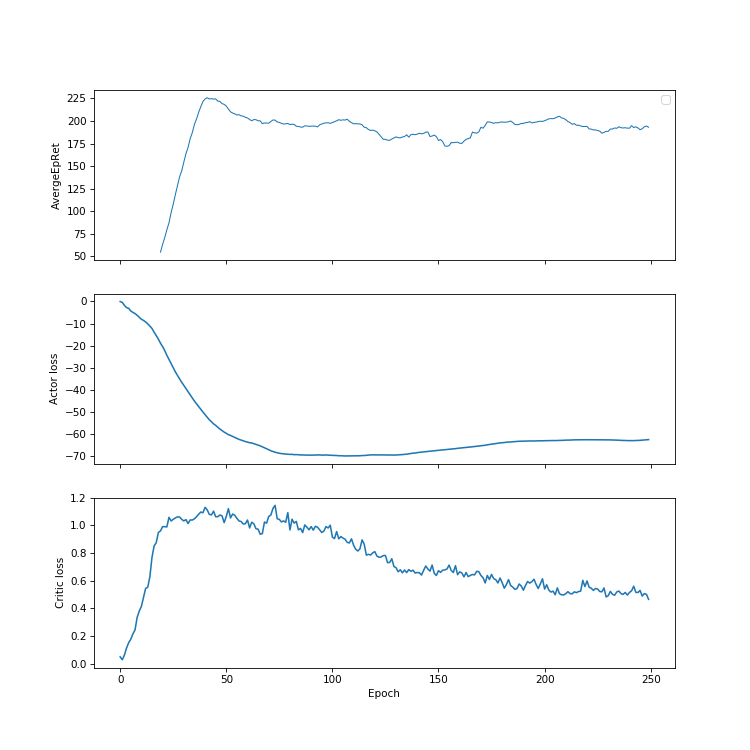

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


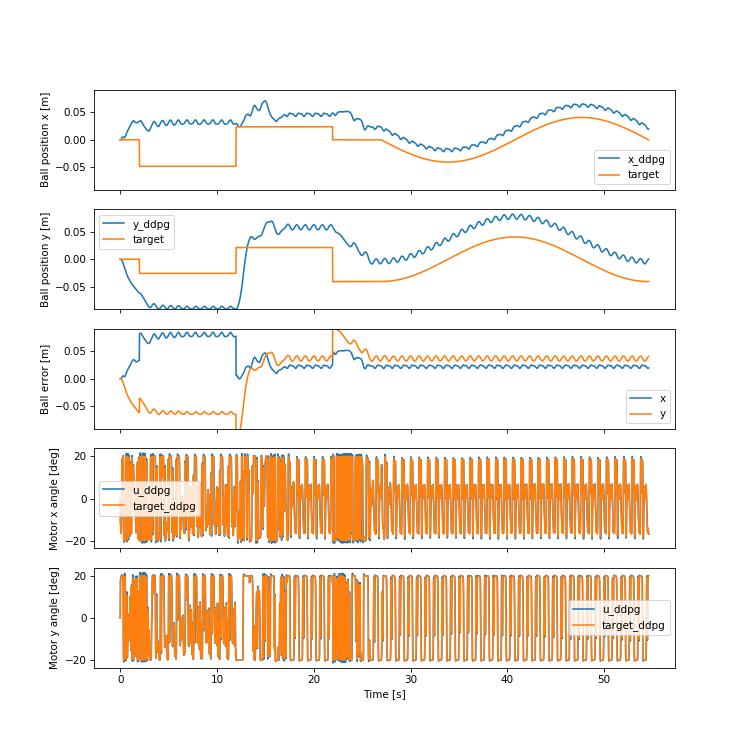

In [44]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [45]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100]
gamma = 0.99
act = torch.nn.Tanh
name='de15_[100]_tanh_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.0419827 ,  0.04152153], dtype=float32), array([0.06531425, 0.02323768], dtype=float32), array([0.0003289 , 0.00157625], dtype=float32))
-26996.04125179029


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


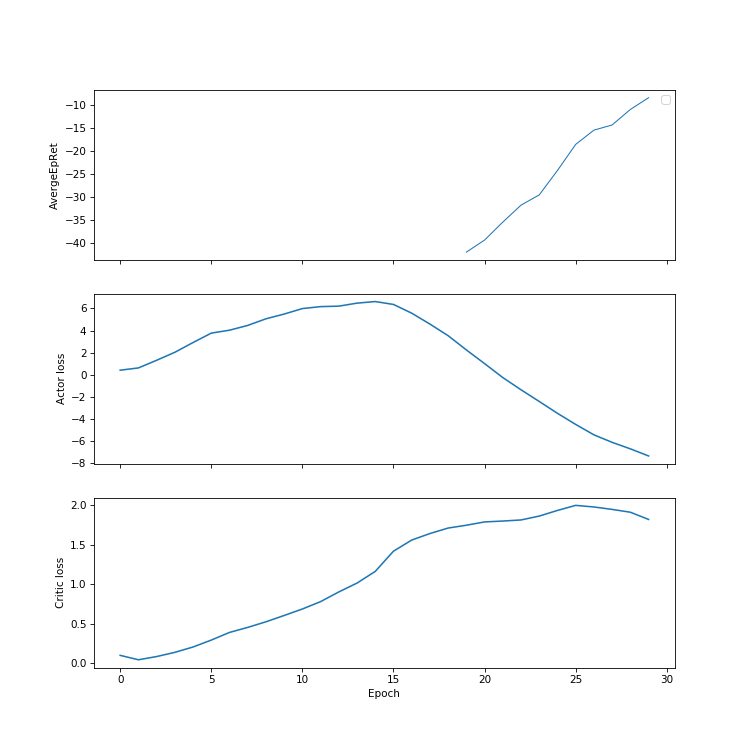

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


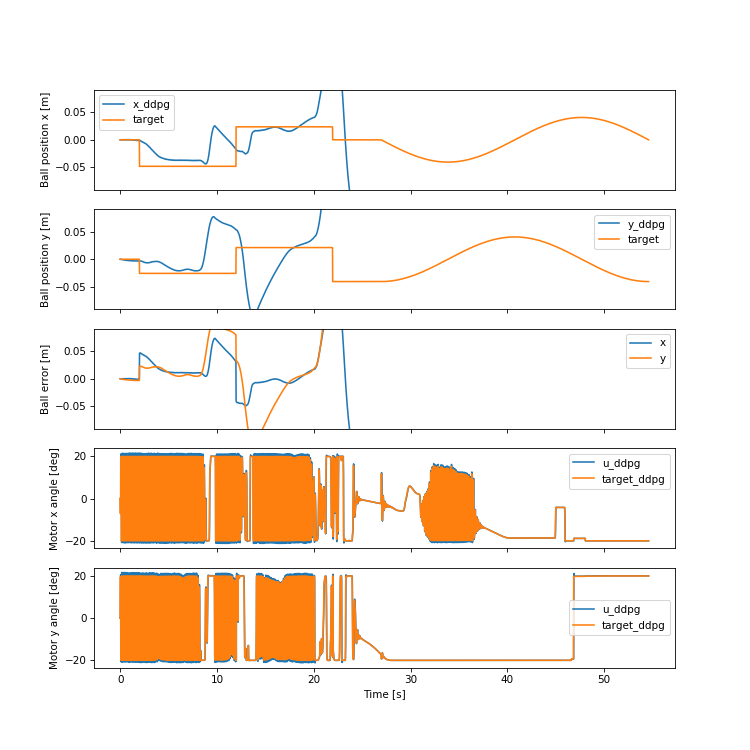

In [46]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [47]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_e_reward
w = 0.3
hidden_size = [100, 50]
gamma = 0.99
act = torch.nn.ReLU
name='le0.3_[100, 50]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05967072,  0.0216022 ], dtype=float32), array([-0.05828809,  0.04515875], dtype=float32), array([-0.00077768, -0.00033439], dtype=float32))
-0.00032826300189580185


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


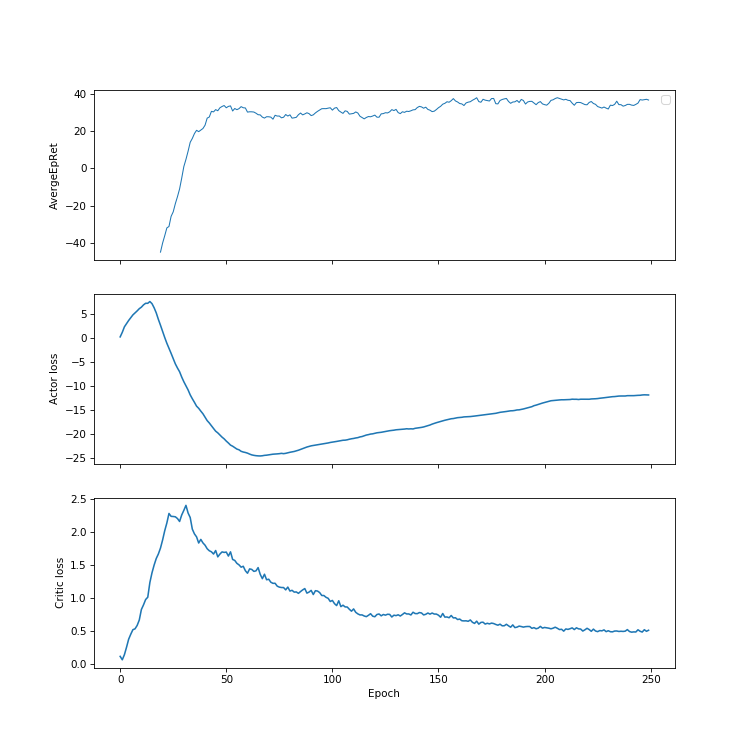

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


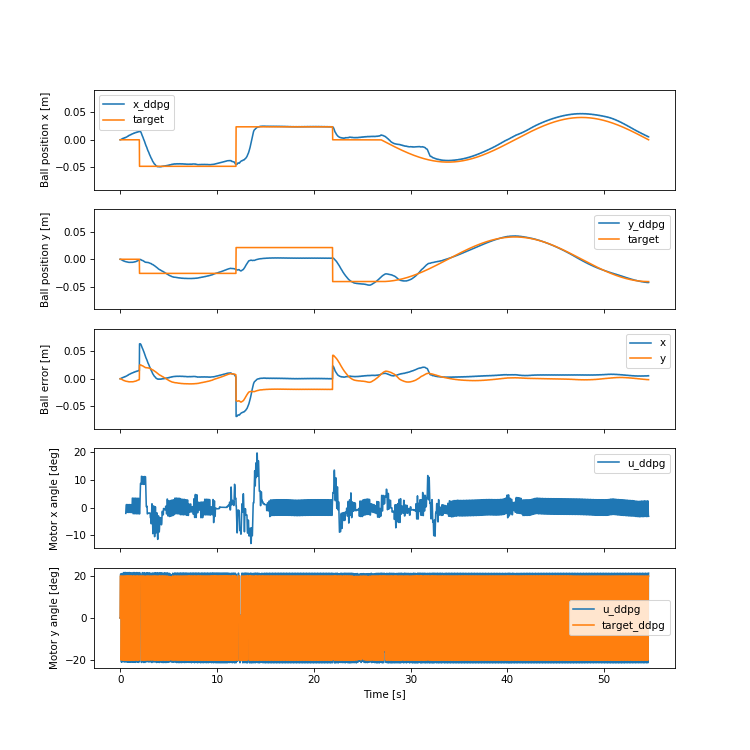

In [59]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()
axs[3].plot(t[29:], np.convolve(angle_ddpg[0, :], np.ones(30), 'valid') / w, label='u_ddpg')
#axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [49]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward
w = 1
hidden_size = [100, 75]
gamma = 0.99
act = torch.nn.ReLU
name='pe1_[100, 75]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.06552237,  0.02703193], dtype=float32), array([-0.06305907, -0.01830413], dtype=float32), array([-0.00107065, -0.00175495], dtype=float32))
-0.0003961273362607473


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


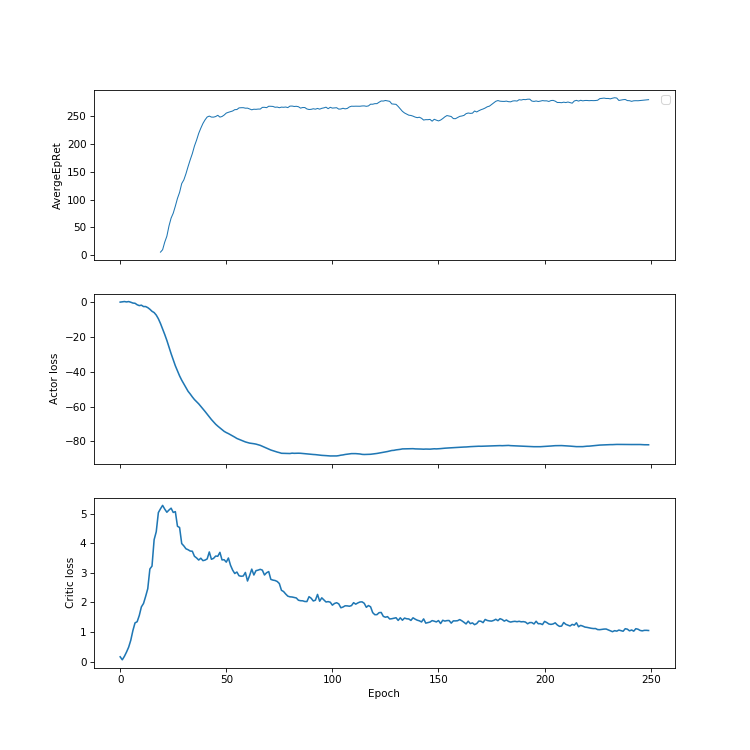

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


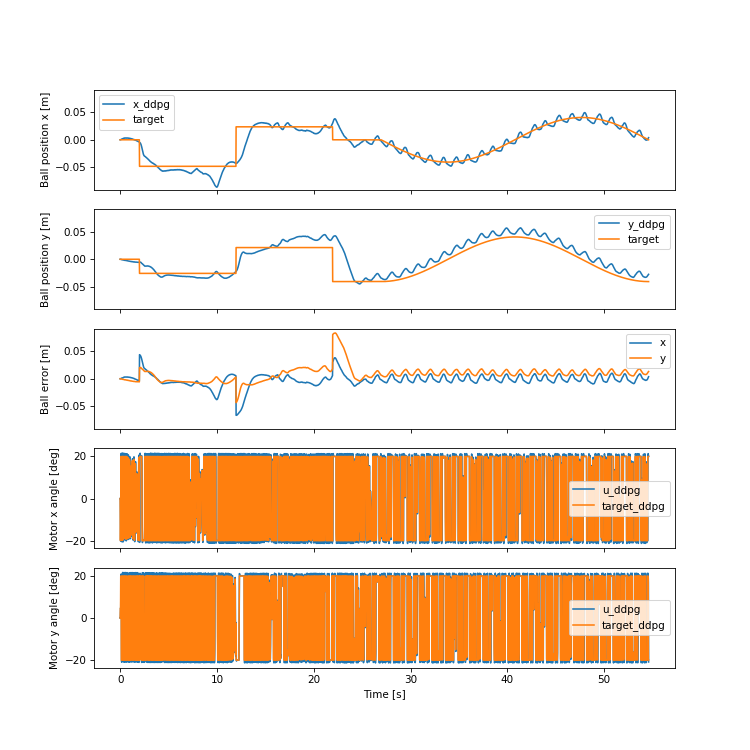

In [50]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [51]:
env = BBEnv
ac = MLPActorCritic
reward_fn = quadratic_e_reward_penality
w = 0.3
hidden_size = [150, 75]
gamma = 0.99
act = torch.nn.ReLU
name='pep0.3_[150, 75]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03707481, -0.03470246], dtype=float32), array([-0.0105779 ,  0.04622046], dtype=float32), array([0.00044119, 0.00295271], dtype=float32))
-0.0032345121926690167


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


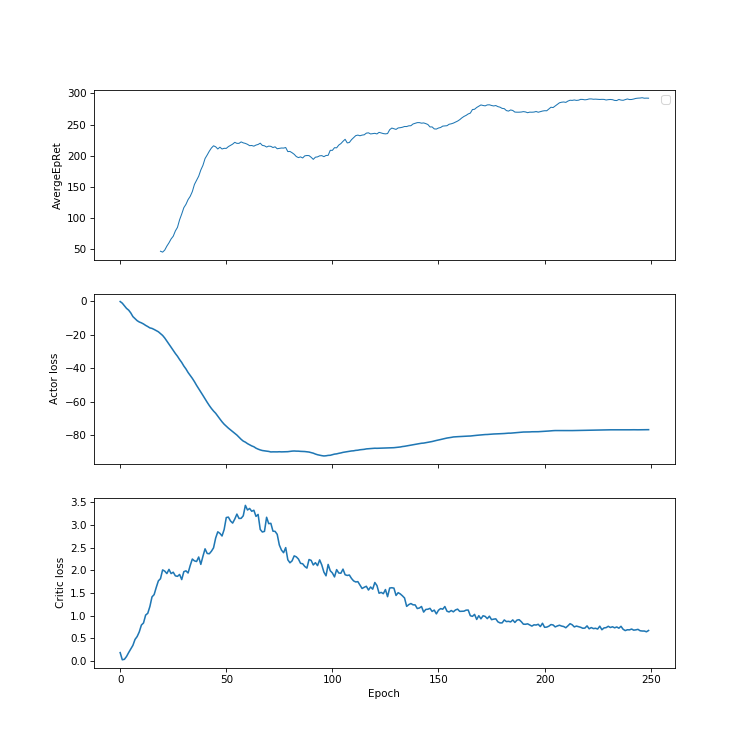

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


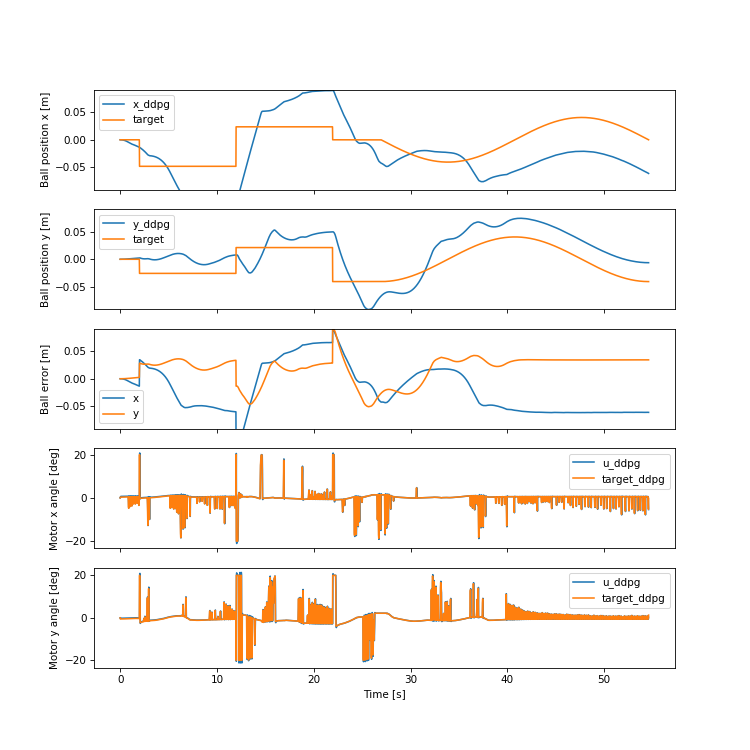

In [52]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()

In [53]:
env = BBEnv
ac = MLPActorCritic
reward_fn = linear_de_reward
w = 15
hidden_size = [100, 100]
gamma = 0.99
act = torch.nn.ReLU
name='de15_[100, 100]_relu_0.99'

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [[0.004883899372829428, -0.0002783757757233037, -0.0028964127848784505, 0.0003109734119487393], [0.00014171512975994787, 0.002639176413894046, 6.8411362451718805e-06, -0.0016660219749745045]], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01431457,  0.07005857], dtype=float32), array([ 0.04499197, -0.05421459], dtype=float32), array([-0.00092339,  0.00230949], dtype=float32))
-0.00032826300189580185


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


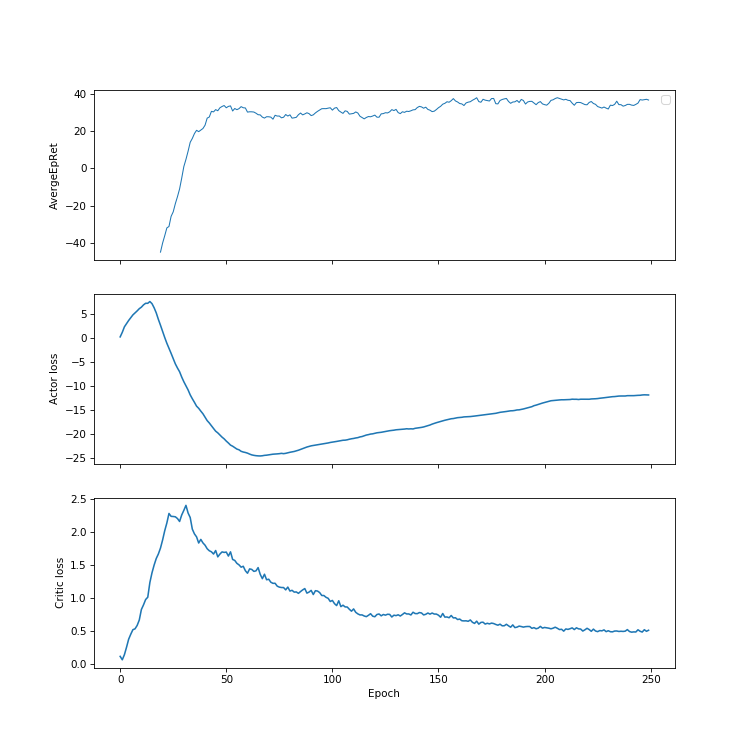

No handles with labels found to put in legend.
/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


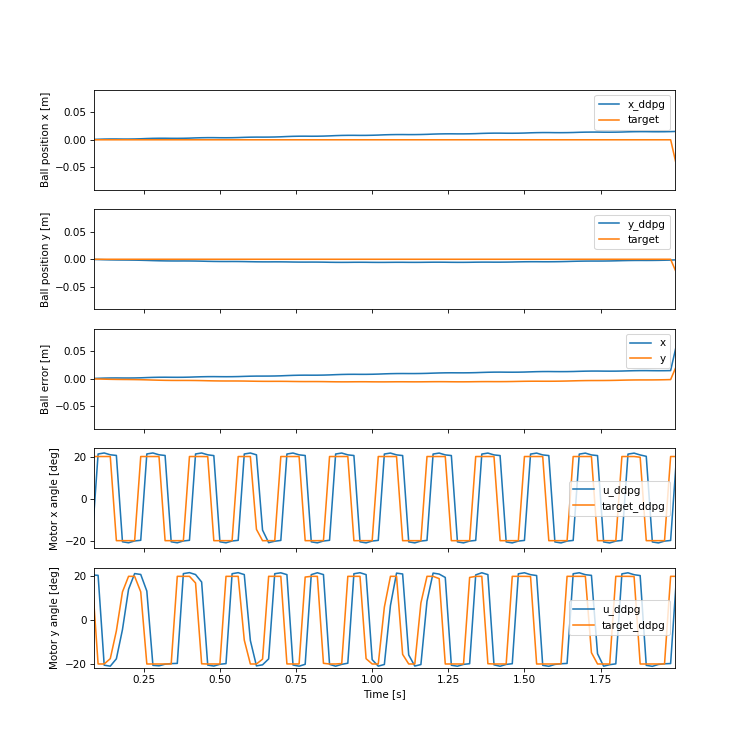

In [54]:
if train:
    spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=act), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = 300000, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
evaluator_ddpg = env()
history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg = evaluator_ddpg.simulate(trained_ac, test_trajectory)

print(loss_ddpg)

log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
axs[0].set_ylabel('AvergeEpRet')
axs[0].legend()
axs[2].set_xlabel('Epoch')

axs[1].plot(log['LossPi'])
axs[1].set_ylabel('Actor loss')
axs[2].set_xlabel('Epoch')

axs[2].plot(log['LossQ'])
axs[2].set_ylabel('Critic loss')
axs[2].set_xlabel('Epoch')

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

axs[0].plot(t, history_ddpg[0, :], label='x_ddpg')
axs[0].plot(t, test_trajectory[0, :], label='target')
axs[0].set_ylabel('Ball position x [m]')
axs[0].set_ylim([-MAX_X, MAX_X])
axs[0].legend()

axs[1].plot(t, history_ddpg[1,:], label='y_ddpg')
axs[1].plot(t, test_trajectory[1, :], label='target')
axs[1].set_ylabel('Ball position y [m]')
axs[1].set_ylim([-MAX_X, MAX_X])
axs[1].legend()

axs[2].plot(t, error_ddpg[0, :], label='x')
axs[2].plot(t, error_ddpg[1, :], label='y')
axs[2].set_ylabel('Ball error [m]')
axs[2].set_ylim([-MAX_X, MAX_X])
axs[2].legend()

axs[3].plot(t, angle_ddpg[0, :], label='u_ddpg')
axs[3].plot(t, u_ddpg[0, :], label='target_ddpg')
axs[3].set_ylabel('Motor x angle [deg]')
axs[3].legend()

axs[4].plot(t, angle_ddpg[1, :], label='u_ddpg')
axs[4].plot(t, u_ddpg[1, :], label='target_ddpg')
axs[4].set_xlabel('Time [s]')
axs[4].set_ylabel('Motor y angle [deg]')
axs[4].legend()

plt.show()